# Evaluating the LSTM Models

The models were trained in a kaggle notebook to use GPU's, but they follwed the same arcuitecture as the one used for loading. 

## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import pandas as pd
import torch
import torch.nn as nn
import pickle
from tqdm import tqdm
import re
from collections import Counter

from toxicity_model.src.plotting_utils import plot_roc_curves, plot_pr_curves, plot_metrics_heatmap, plot_confusion_matrices, plot_mean_metrics, print_classification_report

# Aux Functions

In [ ]:
def evaluate_model(model, test_set, threshold=0.5, plot=True):
    X_test, y_test = test_set
    
    print("Initial data check:")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_test dtype: {y_test.dtype}")
    print(f"y_test range: [{y_test.min()}, {y_test.max()}]")
    
    # Ensure y_test is binary
    y_test_binary = (y_test >= threshold).astype(int)
    print(f"\nAfter binary conversion:")
    print(f"y_test unique values: {np.unique(y_test_binary)}")
    
    print("\nGetting predictions...")
    y_pred_proba = model.predict_proba(X_test)
    print(f"Prediction shape: {y_pred_proba.shape}")
    print(f"Prediction range: [{y_pred_proba.min()}, {y_pred_proba.max()}]")
    
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    toxicity_categories = [
        'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
        'identity_attack', 'insult', 'threat'
    ]
    
    class_names = toxicity_categories[:y_test.shape[1]]
    results = {'per_class': {}, 'overall': {}}
    
    # Store curve data
    curve_data = {
        'fpr': {},
        'tpr': {},
        'roc_auc': {},
        'precision': {},
        'recall': {},
        'avg_precision': {}
    }
    
    # Calculate metrics for each class
    for i, class_name in enumerate(class_names):
        print(f"\nProcessing {class_name}")
        
        y_true_class = y_test_binary[:, i]
        y_score_class = y_pred_proba[:, i]
        y_pred_class = y_pred[:, i]
        
        print(f"True labels unique values: {np.unique(y_true_class)}")
        print(f"Predictions range: [{y_score_class.min()}, {y_score_class.max()}]")
        
        try:
            fpr, tpr, _ = roc_curve(y_true_class, y_score_class)
            roc_auc = auc(fpr, tpr)
            precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)
            avg_precision = average_precision_score(y_true_class, y_score_class)
            report = classification_report(y_true_class, y_pred_class, output_dict=True, zero_division=0)
            cm = confusion_matrix(y_true_class, y_pred_class)
            
            curve_data['fpr'][class_name] = fpr
            curve_data['tpr'][class_name] = tpr
            curve_data['roc_auc'][class_name] = roc_auc
            curve_data['precision'][class_name] = precision
            curve_data['recall'][class_name] = recall
            curve_data['avg_precision'][class_name] = avg_precision
            
            results['per_class'][class_name] = {
                'roc_auc': roc_auc,
                'average_precision': avg_precision,
                'precision': report['1']['precision'],
                'recall': report['1']['recall'],
                'f1_score': report['1']['f1-score'],
                'accuracy': report['accuracy'],
                'confusion_matrix': {
                    'tn': cm[0][0],
                    'fp': cm[0][1],
                    'fn': cm[1][0],
                    'tp': cm[1][1]
                },
                'support': {
                    'negative': report['0']['support'],
                    'positive': report['1']['support']
                }
            }
            
        except Exception as e:
            print(f"Error processing {class_name}: {str(e)}")
            raise
    
    all_metrics = pd.DataFrame([
        {
            'roc_auc': results['per_class'][cn]['roc_auc'],
            'average_precision': results['per_class'][cn]['average_precision'],
            'precision': results['per_class'][cn]['precision'],
            'recall': results['per_class'][cn]['recall'],
            'f1_score': results['per_class'][cn]['f1_score'],
            'accuracy': results['per_class'][cn]['accuracy']
        }
        for cn in class_names
    ])
    
    results['overall'] = {
        'mean_roc_auc': all_metrics['roc_auc'].mean(),
        'mean_average_precision': all_metrics['average_precision'].mean(),
        'mean_precision': all_metrics['precision'].mean(),
        'mean_recall': all_metrics['recall'].mean(),
        'mean_f1_score': all_metrics['f1_score'].mean(),
        'mean_accuracy': all_metrics['accuracy'].mean()
    }
    
    if plot:
        plot_roc_curves(class_names, curve_data['fpr'], curve_data['tpr'], curve_data['roc_auc'])
        plot_pr_curves(class_names, curve_data['recall'], curve_data['precision'], curve_data['avg_precision'])
        plot_confusion_matrices(class_names, results)
        plot_mean_metrics(results)
        print_classification_report(class_names, results)
    
    return results


# Frist Model

In [ ]:
# Constants
MAX_LENGTH = 100
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
MIN_FREQ = 5

toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
                   'identity_attack', 'insult', 'threat']

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

# Load the data (use the same data file you used for training)
df = pd.read_csv("../../data/merged_data/backtranslated_dataset.csv")

# Preprocess texts
df['tokens'] = df['comment_text'].apply(preprocess_text)

# Build vocabulary
word_counts = Counter([word for tokens in df['tokens'] for word in tokens])
vocab_words = ['<pad>', '<unk>'] + [word for word, count in word_counts.items() if count >= MIN_FREQ]
word_to_idx = {word: idx for idx, word in enumerate(vocab_words)}

print(f"Vocabulary size: {len(word_to_idx)}")

Vocabulary size: 60564


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, word_to_idx=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                            bidirectional=True, num_layers=2, dropout=0.2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        self.word_to_idx = word_to_idx
        self.max_length = MAX_LENGTH
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dropped = self.dropout(hidden_cat)
        output = self.fc(dropped)
        return output

    def preprocess_text(self, text):
        """Preprocess single text input"""
        text = str(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'[^\w\s]', '', text.lower())
        return text.split()

    def texts_to_tensor(self, texts, batch_size=32):
        """Convert texts to tensors in batches"""
        all_indices = []
        for text in texts:
            tokens = self.preprocess_text(text)
            indices = [self.word_to_idx.get(token, self.word_to_idx['<unk>']) 
                      for token in tokens[:self.max_length]]
            
            # Pad sequence
            if len(indices) < self.max_length:
                indices += [self.word_to_idx['<pad>']] * (self.max_length - len(indices))
            else:
                indices = indices[:self.max_length]
            
            all_indices.append(indices)
            
        return torch.tensor(all_indices, dtype=torch.long)

    def predict_proba(self, texts, batch_size=128):
        """Optimized batch processing for predict_proba"""
        self.eval()
        device = next(self.parameters()).device  # Get the device model is on
        all_predictions = []
        
        try:
            # Convert all texts to tensors at once before batching
            print("Converting texts to tensors...")
            all_indices = []
            for text in tqdm(texts):
                tokens = self.preprocess_text(text)
                indices = [self.word_to_idx.get(token, self.word_to_idx['<unk>']) 
                        for token in tokens[:self.max_length]]
                
                # Pad sequence
                if len(indices) < self.max_length:
                    indices += [self.word_to_idx['<pad>']] * (self.max_length - len(indices))
                else:
                    indices = indices[:self.max_length]
                
                all_indices.append(indices)
            
            all_tensors = torch.tensor(all_indices, dtype=torch.long)
            
            # Process in batches with progress bar
            print("Making predictions...")
            with torch.no_grad():
                for i in tqdm(range(0, len(texts), batch_size)):
                    batch_tensor = all_tensors[i:i + batch_size].to(device)
                    outputs = self(batch_tensor)
                    predictions = torch.sigmoid(outputs).cpu()  # Move to CPU before converting to numpy
                    all_predictions.append(predictions)

            # Concatenate all predictions at once
            return torch.cat(all_predictions, dim=0).numpy()

        except Exception as e:
            print(f"Error in predict_proba: {e}")
            raise e

def load_lstm_model(model_path, vocab_size, word_to_idx, embedding_dim=300, 
                   hidden_dim=128, num_labels=7):
    """Load model with improved error handling and logging"""
    try:
        print("Initializing model...")
        model = LSTMClassifier(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_labels=num_labels,
            word_to_idx=word_to_idx
        )
        
        print("Loading state dict...")
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        
        print("Setting model to eval mode...")
        model.eval()
        
        return model

    except Exception as e:
        print(f"Error loading model: {e}")
        raise

print("Loading model...")
model = load_lstm_model(
    model_path='models/lstm_model.pt',
    vocab_size=len(word_to_idx),
    word_to_idx=word_to_idx,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_labels=len(toxic_categories)
)

Loading model...
Initializing model...
Loading state dict...
Setting model to eval mode...


In [36]:
# Load and evaluate test data
print("Loading test data...")
test_df = pd.read_csv("../../data/merged_data/test_merged.csv")

X_test = test_df['comment_text']
y_test = test_df[toxic_categories].values
y_test = (y_test >= 0.5).astype(int)


Loading test data...


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_77514/692015175.py:3: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("../../data/merged_data/test_merged.csv")


In [47]:
def prepare_test_data(X_test, y_test, threshold=0.5):
    """
    Prepare test data for evaluation by ensuring correct formats
    """
    # Convert y_test to binary
    y_test_binary = (y_test >= threshold).astype(int)
    
    # Verify the conversion
    print("\nData preparation verification:")
    print(f"Original y_test range: [{y_test.min():.4f}, {y_test.max():.4f}]")
    print(f"Binary y_test unique values: {np.unique(y_test_binary)}")
    print(f"Binary y_test shape: {y_test_binary.shape}")
    
    return X_test, y_test_binary

Starting evaluation...
Initial data check:
y_test shape: (258619, 7)
y_test dtype: int64
y_test range: [0, 1]

After binary conversion:
y_test unique values: [0 1]

Getting predictions...
Converting texts to tensors...


100%|██████████| 258619/258619 [00:04<00:00, 59449.47it/s]


Making predictions...


100%|██████████| 2021/2021 [04:23<00:00,  7.68it/s]


Prediction shape: (258619, 7)
Prediction range: [1.7054068379707132e-08, 0.999987006187439]

Processing toxicity
True labels unique values: [0 1]
Predictions range: [0.00038133919588290155, 0.9999815225601196]

Processing severe_toxicity
True labels unique values: [0 1]
Predictions range: [1.7054068379707132e-08, 0.9999817609786987]

Processing obscene
True labels unique values: [0 1]
Predictions range: [1.3586996828962583e-05, 0.999987006187439]

Processing sexual_explicit
True labels unique values: [0 1]
Predictions range: [2.494459465651744e-07, 0.9865211248397827]

Processing identity_attack
True labels unique values: [0 1]
Predictions range: [8.928944225772284e-06, 0.999779999256134]

Processing insult
True labels unique values: [0 1]
Predictions range: [5.7870933233061805e-05, 0.9998090863227844]

Processing threat
True labels unique values: [0 1]
Predictions range: [9.330239691962561e-08, 0.9999462366104126]


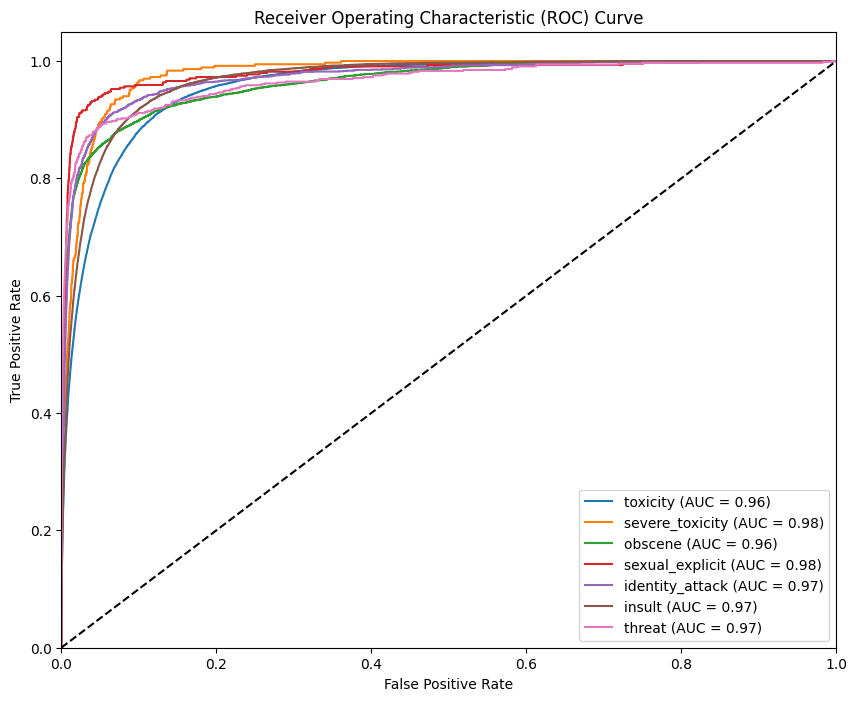

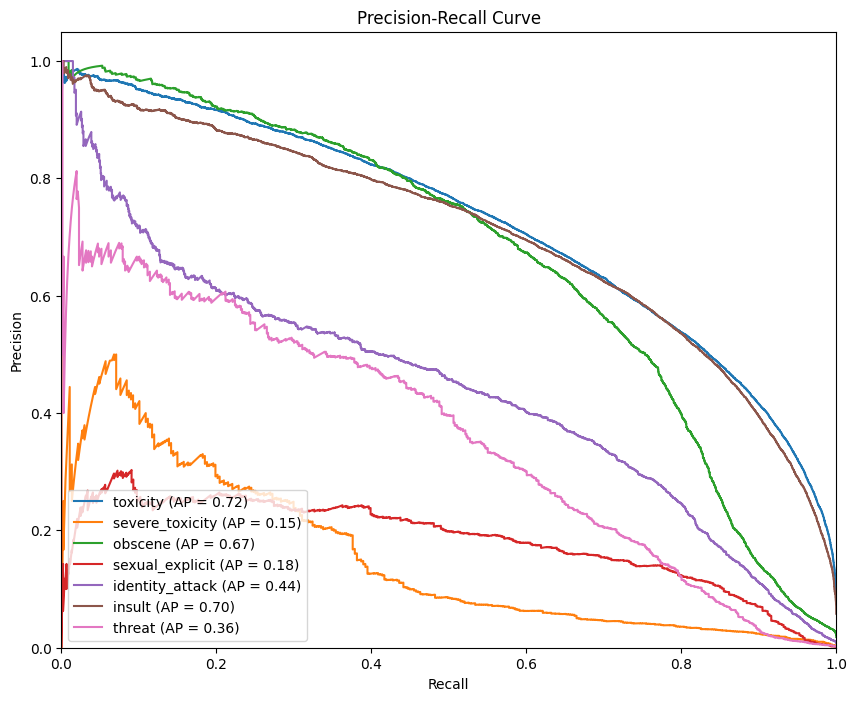

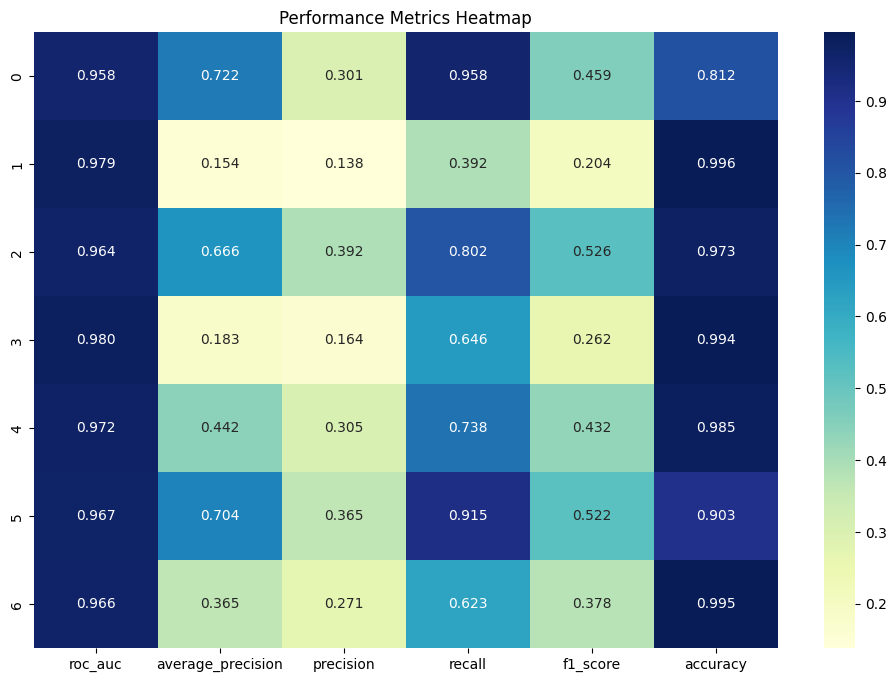

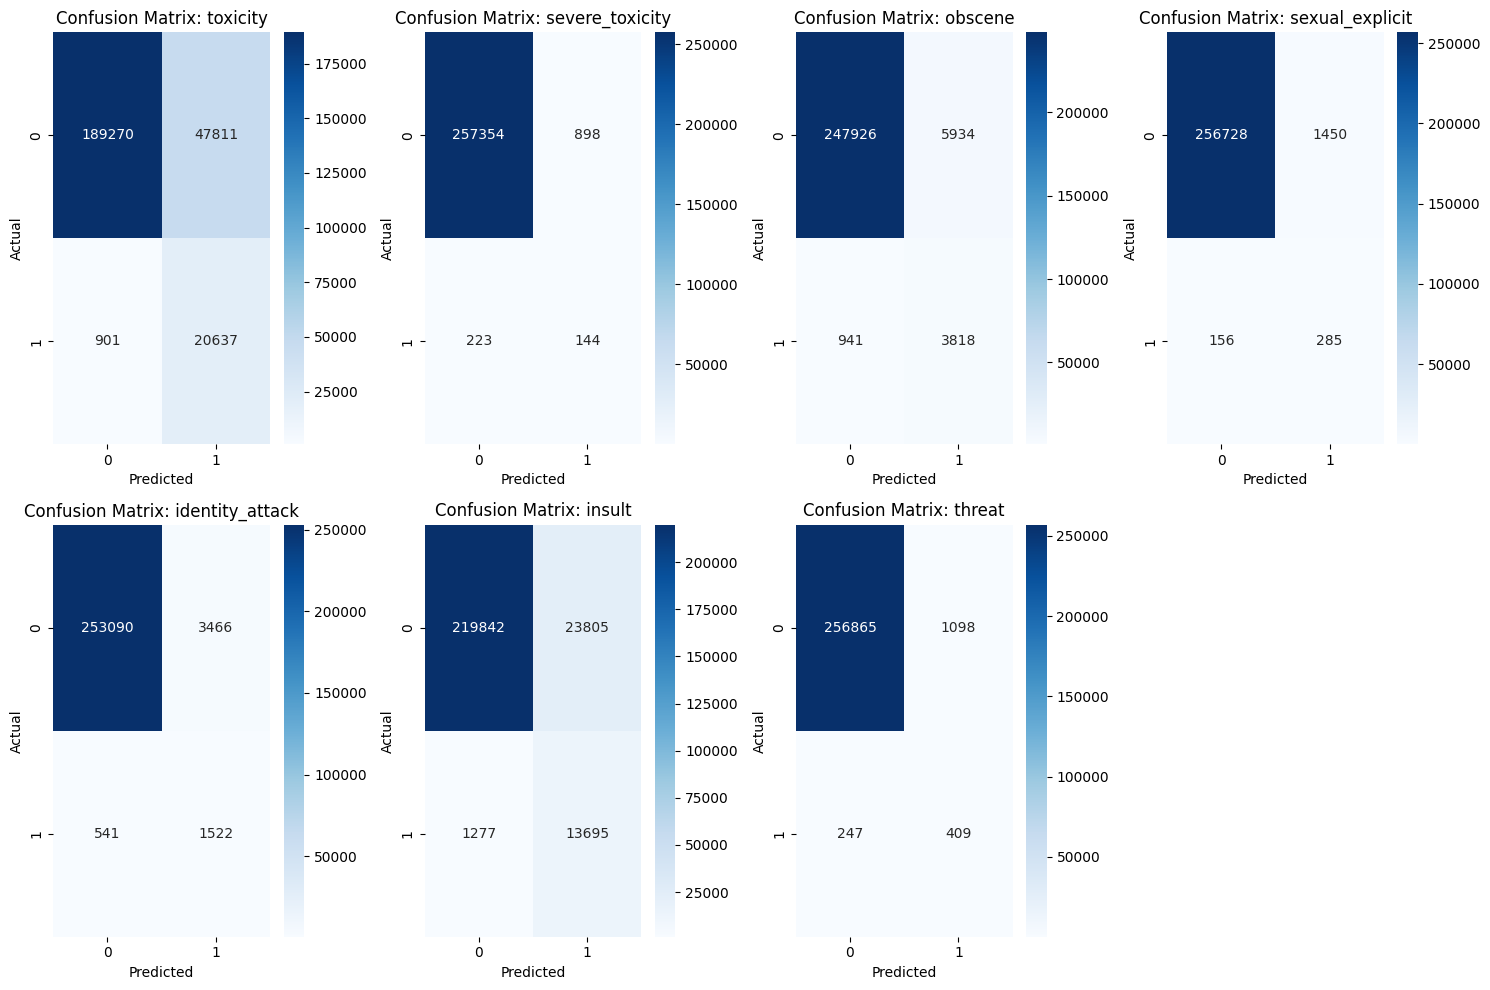

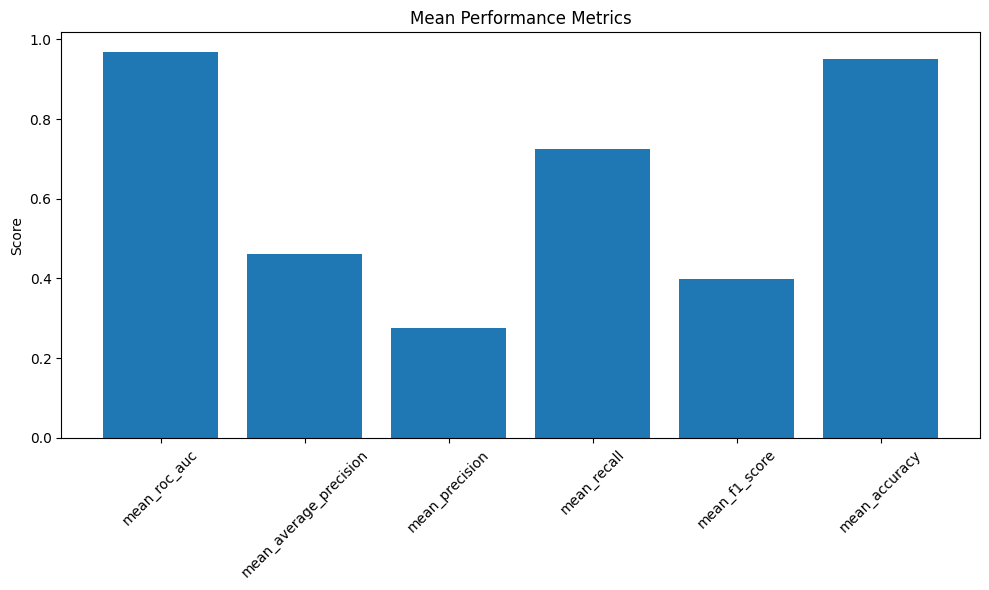


Classification Report:

toxicity:
Precision: 0.301
Recall: 0.958
F1-score: 0.459
Support: 258619.0

severe_toxicity:
Precision: 0.138
Recall: 0.392
F1-score: 0.204
Support: 258619.0

obscene:
Precision: 0.392
Recall: 0.802
F1-score: 0.526
Support: 258619.0

sexual_explicit:
Precision: 0.164
Recall: 0.646
F1-score: 0.262
Support: 258619.0

identity_attack:
Precision: 0.305
Recall: 0.738
F1-score: 0.432
Support: 258619.0

insult:
Precision: 0.365
Recall: 0.915
F1-score: 0.522
Support: 258619.0

threat:
Precision: 0.271
Recall: 0.623
F1-score: 0.378
Support: 258619.0

Overall Results:
mean_roc_auc: 0.9693
mean_average_precision: 0.4623
mean_precision: 0.2767
mean_recall: 0.7250
mean_f1_score: 0.3976
mean_accuracy: 0.9510

Per-class Results:

toxicity:
F1-Score: 0.4587
Precision: 0.3015
Recall: 0.9582
ROC AUC: 0.9575

severe_toxicity:
F1-Score: 0.2044
Precision: 0.1382
Recall: 0.3924
ROC AUC: 0.9788

obscene:
F1-Score: 0.5262
Precision: 0.3915
Recall: 0.8023
ROC AUC: 0.9638

sexual_explic

In [ ]:
# Test the evaluation
print("Starting evaluation...")
try:
    if isinstance(X_test, pd.Series):
        X_test = X_test.values
    
    # Convert y_test to binary if needed
    if not np.array_equal(y_test, y_test.astype(bool).astype(int)):
        print("Converting y_test to binary format...")
        y_test = (y_test >= 0.5).astype(int)
    
    test_set = (X_test, y_test)
    evaluation_results = evaluate_model(model, test_set, threshold=0.3, plot=True)
    
    # Print results
    print("\nOverall Results:")
    for metric, value in evaluation_results['overall'].items():
        print(f"{metric}: {value:.4f}")

    print("\nPer-class Results:")
    for category, metrics in evaluation_results['per_class'].items():
        print(f"\n{category}:")
        print(f"F1-Score: {metrics['f1_score']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")
except Exception as e:
    print(f"Evaluation failed: {e}")
    print("\nDebug information:")
    print(f"X_test type: {type(X_test)}")
    print(f"y_test type: {type(y_test)}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_test unique values: {np.unique(y_test)}")

# Second Model

In [ ]:
# Cosntants
MAX_LENGTH = 200
EMBEDDING_DIM = 400
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
MIN_FREQ = 5

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, word_to_idx=None, max_length=MAX_LENGTH):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True,
                            bidirectional=True, num_layers=2, dropout=0.2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        self.word_to_idx = word_to_idx
        self.max_length = max_length

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden_cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        dropped = self.dropout(hidden_cat)
        output = self.fc(dropped)
        return output

    def preprocess_text(self, text):
        """Preprocess single text input"""
        text = str(text)
        text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'[^\\w\\s]', '', text.lower())
        return text.split()

    def texts_to_tensor(self, texts):
        """Convert list of texts to tensor indices"""
        all_indices = []
        for text in texts:
            tokens = self.preprocess_text(text)
            indices = [self.word_to_idx.get(token, self.word_to_idx['<unk>'])
                       for token in tokens[:self.max_length]]
            if len(indices) < self.max_length:
                indices += [self.word_to_idx['<pad>']] * (self.max_length - len(indices))
            all_indices.append(indices)
        return torch.tensor(all_indices, dtype=torch.long)

    def predict_proba(self, texts, batch_size=128):
        """Optimized batch processing for predict_proba"""
        self.eval()
        device = next(self.parameters()).device  # Get the device model is on
        all_predictions = []
        
        try:
            # Convert all texts to tensors at once before batching
            print("Converting texts to tensors...")
            all_indices = []
            for text in tqdm(texts):
                tokens = self.preprocess_text(text)
                indices = [self.word_to_idx.get(token, self.word_to_idx['<unk>']) 
                        for token in tokens[:self.max_length]]
                
                # Pad sequence
                if len(indices) < self.max_length:
                    indices += [self.word_to_idx['<pad>']] * (self.max_length - len(indices))
                else:
                    indices = indices[:self.max_length]
                
                all_indices.append(indices)
            
            all_tensors = torch.tensor(all_indices, dtype=torch.long)
            
            # Process in batches with progress bar
            print("Making predictions...")
            with torch.no_grad():
                for i in tqdm(range(0, len(texts), batch_size)):
                    batch_tensor = all_tensors[i:i + batch_size].to(device)
                    outputs = self(batch_tensor)
                    predictions = torch.sigmoid(outputs).cpu()  # Move to CPU before converting to numpy
                    all_predictions.append(predictions)

            # Concatenate all predictions at once
            return torch.cat(all_predictions, dim=0).numpy()

        except Exception as e:
            print(f"Error in predict_proba: {e}")
            raise e


In [75]:
def load_lstm_model(model_path, vocab_size, word_to_idx, embedding_dim=EMBEDDING_DIM,
                    hidden_dim=HIDDEN_DIM, num_labels=len(toxic_categories), max_length=MAX_LENGTH):
    """Load LSTMClassifier with updated architecture and hyperparameters"""
    try:
        print("Initializing model...")
        model = LSTMClassifier(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_labels=num_labels,
            word_to_idx=word_to_idx,
            max_length=max_length  # Atualizado conforme o novo MAX_LENGTH
        )

        print("Loading state dict...")
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)

        print("Model loaded successfully.")
        model.eval()
        return model

    except Exception as e:
        print(f"Error loading model: {e}")
        raise

with open("models/word_to_idx_2.pkl", "rb") as f:
    word_to_idx = pickle.load(f)

Initializing model...
Loading state dict...
Model loaded successfully.
Initial data check:
y_test shape: (258619, 7)
y_test dtype: int64
y_test range: [0, 1]

After binary conversion:
y_test unique values: [0 1]

Getting predictions...
Converting texts to tensors...


100%|██████████| 258619/258619 [00:05<00:00, 51007.10it/s]


Making predictions...


100%|██████████| 2021/2021 [08:36<00:00,  3.91it/s]


Prediction shape: (258619, 7)
Prediction range: [0.009374023415148258, 0.8946009874343872]

Processing toxicity
True labels unique values: [0 1]
Predictions range: [0.024639997631311417, 0.877349317073822]

Processing severe_toxicity
True labels unique values: [0 1]
Predictions range: [0.009374023415148258, 0.7383564710617065]

Processing obscene
True labels unique values: [0 1]
Predictions range: [0.018318092450499535, 0.8946009874343872]

Processing sexual_explicit
True labels unique values: [0 1]
Predictions range: [0.025894083082675934, 0.8380522727966309]

Processing identity_attack
True labels unique values: [0 1]
Predictions range: [0.010216014459729195, 0.23493437469005585]

Processing insult
True labels unique values: [0 1]
Predictions range: [0.022583600133657455, 0.3990173637866974]

Processing threat
True labels unique values: [0 1]
Predictions range: [0.03951532021164894, 0.6826479434967041]


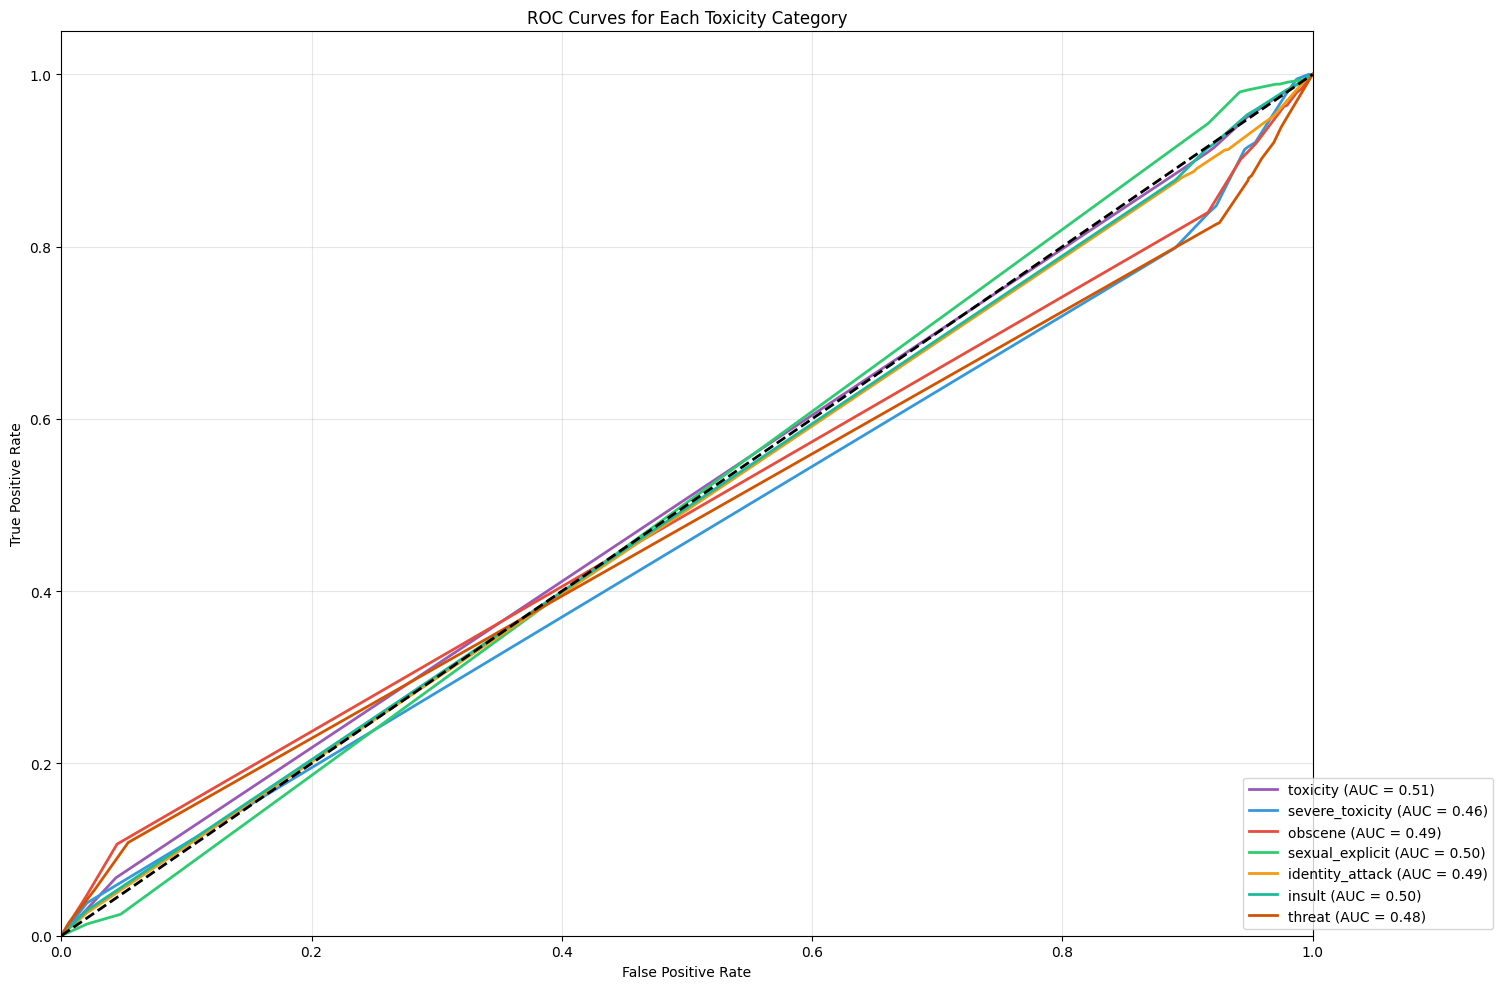

KeyError: 0

<Figure size 1500x1000 with 0 Axes>

In [83]:
model = load_lstm_model(
    model_path='models/lstm_model_2.pt',
    vocab_size=len(word_to_idx),
    word_to_idx=word_to_idx
)

evaluate_model(model, test_set, threshold=0.5, plot=True)

# Third Model

WARNING: The glove file and model files were removed from the repository to avoid large files being tracked by Git. As a result, this code will not run without those files. The code is being kept in the repository strictly for documentation purposes, to illustrate the model architecture and structure.

In [ ]:
with open("models/best_word_to_idx.pkl", "rb") as f:
    word_to_idx = pickle.load(f)

print(f"Vocabulary size: {len(word_to_idx)}")


EMBEDDING_DIM = 300 
glove_path = "models/glove.42B.300d.txt"

# Load GloVe embeddings
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print(f"Loaded {len(glove_embeddings)} GloVe vectors.")

# Build embedding matrix
vocab_size = len(word_to_idx)
embedding_matrix = np.random.normal(0, 1, (vocab_size, EMBEDDING_DIM)).astype(np.float32)

found = 0
for word, idx in word_to_idx.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
        found += 1

print(f"Found {found} out of {vocab_size} words in GloVe.")

In [ ]:
# Define LSTMClassifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False, padding_idx=padding_idx
        )
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=3, batch_first=True,
            bidirectional=True, dropout=0.3
        )
        self.dropout = nn.Dropout(0.5)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=1)
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)
        dropped = self.dropout(context)
        output = self.fc(dropped)
        return output
    
    def preprocess_text(self, text):
        import re
        text = str(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'[^\w\s]', '', text.lower())
        return text.split()
    
    def texts_to_tensor(self, texts, word_to_idx, max_length=300):
        all_indices = []
        for text in texts:
            tokens = self.preprocess_text(text)
            indices = [word_to_idx.get(token, word_to_idx['<unk>']) for token in tokens[:max_length]]
            if len(indices) < max_length:
                indices += [word_to_idx['<pad>']] * (max_length - len(indices))
            all_indices.append(indices)
        return torch.tensor(all_indices, dtype=torch.long)

    def predict_proba(self, texts, batch_size=64):
        self.eval()
        device = next(self.parameters()).device
        all_preds = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size)):
                batch_texts = texts[i:i+batch_size]
                batch_tensor = self.texts_to_tensor(batch_texts, word_to_idx).to(device)
                outputs = torch.sigmoid(self(batch_tensor))
                all_preds.append(outputs.cpu().numpy())
        return np.vstack(all_preds)

# Load your saved model state
def load_lstm_model(model_path, vocab_size, embedding_dim, hidden_dim, num_labels,
                    embedding_matrix, padding_idx=0):
    model = LSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_labels=num_labels,
        embedding_matrix=embedding_matrix,
        padding_idx=padding_idx
    )
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return model

model_path = "models/best_lstm_model.pt"
HIDDEN_DIM = 256  
NUM_LABELS = 7    

model = load_lstm_model(
    model_path=model_path,
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_labels=NUM_LABELS,
    embedding_matrix=embedding_matrix
)


Vocabulary size: 60564
Loaded 1917494 GloVe vectors.
Found 54891 out of 60564 words in GloVe.


Initial data check:
y_test shape: (258619, 7)
y_test dtype: int64
y_test range: [0, 1]

After binary conversion:
y_test unique values: [0 1]

Getting predictions...


100%|██████████| 4041/4041 [56:01<00:00,  1.20it/s] 


Prediction shape: (258619, 7)
Prediction range: [5.6347224017372355e-05, 0.9999772310256958]

Processing toxicity
True labels unique values: [0 1]
Predictions range: [0.0011823367094621062, 0.9998443126678467]

Processing severe_toxicity
True labels unique values: [0 1]
Predictions range: [5.6347224017372355e-05, 0.9997974038124084]

Processing obscene
True labels unique values: [0 1]
Predictions range: [0.0005912359920330346, 0.9999772310256958]

Processing sexual_explicit
True labels unique values: [0 1]
Predictions range: [0.0004984529805369675, 0.9996681213378906]

Processing identity_attack
True labels unique values: [0 1]
Predictions range: [0.000248748721787706, 0.9994148015975952]

Processing insult
True labels unique values: [0 1]
Predictions range: [0.002472799504175782, 0.9998311996459961]

Processing threat
True labels unique values: [0 1]
Predictions range: [0.0007255396340042353, 0.9998056292533875]


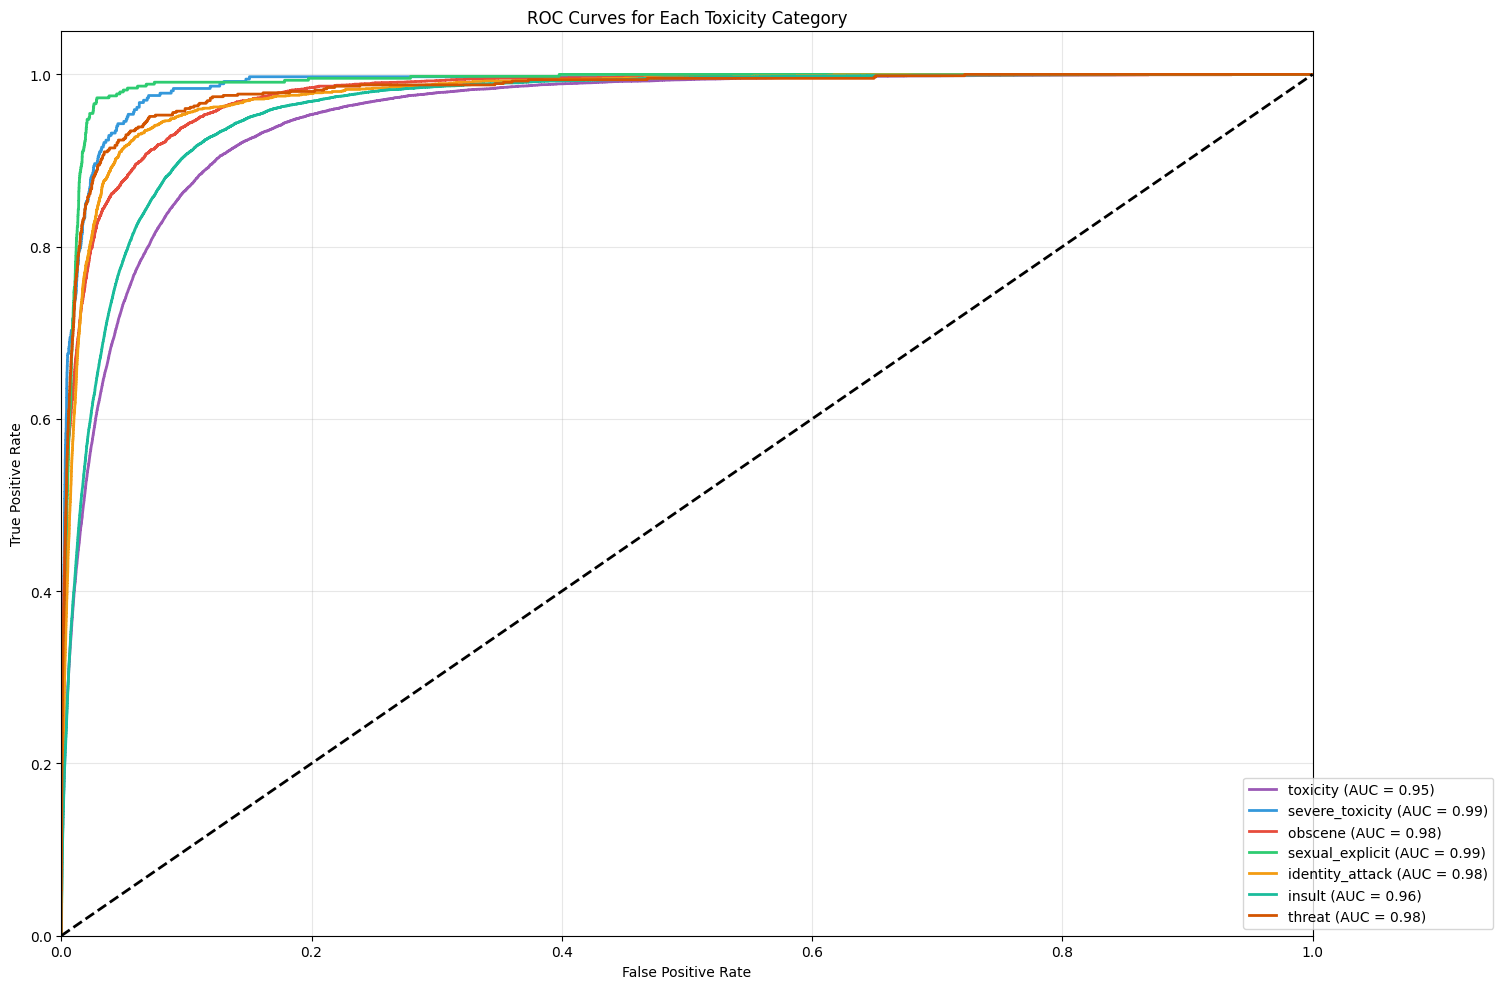

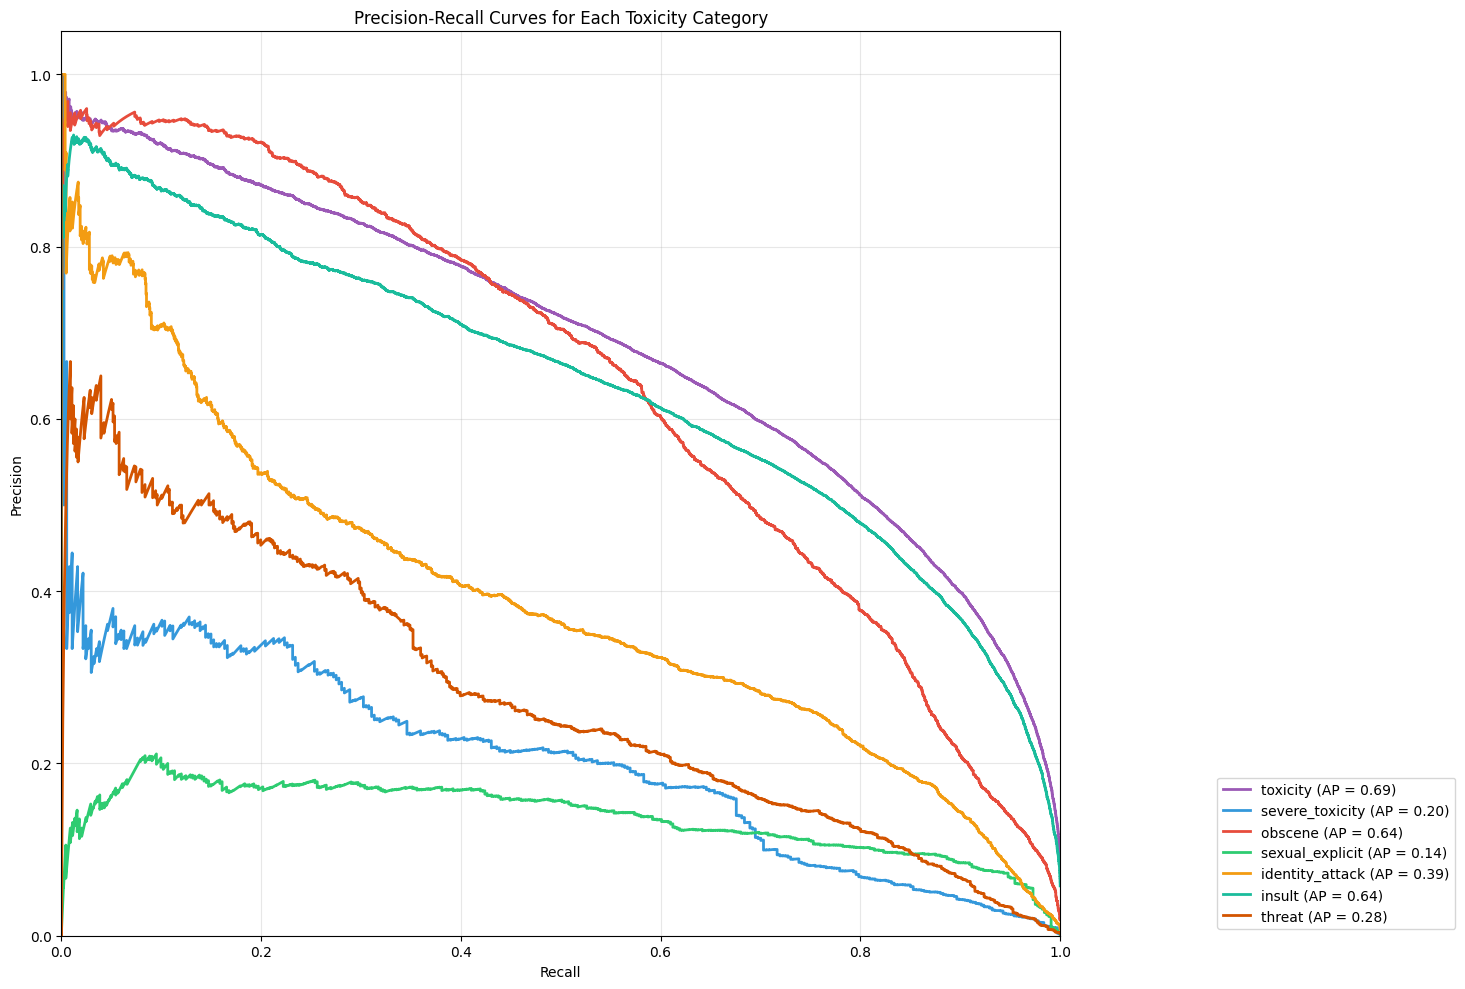

NameError: name 'metrics_df' is not defined

In [44]:
results = evaluate_model(model, test_set, threshold=0.5, plot=True)